# Offline Exercise

This notebook has the questions and instructions for the offline exercise. If you haven't already, please go through the `README.md` file before you begin answering the questions here.

Make sure you do NOT commit your answers back to the repo. Instead, copy-paste this notebook together with the `touches.sqlite3` file to a separate folder in your machine, type your answers in that copied notebook, and when you're done, share the new Jupyter notebook back with the recruiter together with additional modules, graphs etc. that you may have. You would need to use the data in the `touches.sqlite3` file to answer all the questions.

### Question 1. Find the most common industry out of all the companies that were `contacted`.

In [1]:
# !pip install plotly

In [2]:
# import statements for all of the packages that will or may be used.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
from sqlite3 import Error
import os

import plotly 
import plotly.express as px
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

%matplotlib inline

# from google.colab import drive, files
# drive.mount('/content/gdrive')

In [3]:
def create_connection(db_file):
    """ 
    create a database connection to the SQLite database specified by the db_file
      :param db_file: database file
      :return: Connection object or None
    """
    conn = None
    try:
        conn = sqlite3.connect(db_file)
    except Error as error:
        print("Failed to connect to database file - ", error)

    return conn

In [4]:
database = r"touches.sqlite3"

# creating a database connection
conn = create_connection(database)

In [5]:
qry1 = """

SELECT co.id AS CompanyID
	, co.industry
	, COUNT(DISTINCT co.id) AS Record_Count
FROM companies co
INNER JOIN persons p 
	ON p.company_id = co.id
		AND p.job_seniority NOT IN ('Individual Contributor', 'Unknown')
INNER JOIN touches t 
	ON t.person_id = p.id
		AND t.STATUS = 'completed'
WHERE co.industry != ''
GROUP BY co.industry
ORDER BY COUNT(DISTINCT co.id) DESC 

"""

df1 = pd.read_sql_query(qry1, conn)

# Verify that result of SQL query is stored in the dataframe
df1.head()

,CompanyID,industry,Record_Count
0,3144,Internet Software & Services,3502
1,3198,Professional Services,999
2,862,Consulting,422
3,3432,Computer Software,374
4,4669,Technology,359


In [6]:
print(f"{df1.iloc[0][1]} is the most common industry out of all the companies that were contacted.")

Internet Software & Services is the most common industry out of all the companies that were contacted.


### Question 2. What is the most common touch type sellers use when they’re making their first touch with a person? What about first touch with a company?

In [7]:
# !pip install ipython-sql

In [8]:
%load_ext sql

In [9]:
%sql sqlite:///touches.sqlite3

In [10]:
%%sql
SELECT touch_type, COUNT(touch_type) AS Count FROM (
SELECT ROW_NUMBER() OVER(PARTITION BY t.person_id ORDER BY t.person_id, t.touch_scheduled_on) AS RowNum,
		t.id,
       t.person_id,
       t.touch_scheduled_on,
       t.status, 
       t.touch_type,
       p.company_id,
       p.job_seniority
FROM touches t 
	Inner Join persons p ON p.id = (SELECT p.Id FROM persons p WHERE p.id = t.person_id ORDER BY p.id LIMIT 1)
ORDER BY t.person_id, t.id 
) t
WHERE RowNum = 1
GROUP BY touch_type 
ORDER BY COUNT(touch_type) DESC;

 * sqlite:///touches.sqlite3
Done.


touch_type,Count
Other,31057
Email,18384
Phone,10800
Integration,794


In [11]:
%%sql
SELECT touch_type, COUNT(touch_type) AS Count FROM (
 SELECT ROW_NUMBER() OVER(PARTITION BY co.id ORDER BY co.id, t.touch_scheduled_on) AS RowNum,
    t.id,
    t.person_id,
    t.touch_scheduled_on,
    t.status, 
    t.touch_type,
    p.job_seniority,
    co.id AS company_id,
    co.industry       
 FROM touches t 
	Inner Join persons p ON p.id = (SELECT p.Id FROM persons p WHERE p.id = t.person_id ORDER BY p.id LIMIT 1)
	Inner Join companies co ON co.id = (SELECT co.id FROM companies co WHERE co.id = p.company_id ORDER BY co.id LIMIT 1)
 ORDER BY co.id, t.id 
) t
 WHERE RowNum = 1
 GROUP BY touch_type 
 ORDER BY COUNT(touch_type) DESC;

 * sqlite:///touches.sqlite3
Done.


touch_type,Count
Other,4975
Email,3511
Phone,1607
Integration,102


In [12]:
result = _

In [13]:
df2 = result.DataFrame()

df2.head()

,touch_type,Count
0,Other,4975
1,Email,3511
2,Phone,1607
3,Integration,102


#### The most common touch type sellers use when they’re making their first touch with a person and a company is `Other`

### Question 3. Describe the distribution of the job seniorities of people that a seller will first try to contact within a company.

To answer this question, you may use visuals, graphs, bunch of scores, tables, writeups - whatever you want. We literally want you to "describe" the distribution to us in the best way you can!

(Note: this question doesn't really have one right answer. It's more about your style of communicating the results.)

In [14]:
qry3 = """

SELECT job_seniority, COUNT(job_seniority) AS Count FROM (
SELECT ROW_NUMBER() OVER(PARTITION BY p.id ORDER BY p.id, t.touch_scheduled_on) AS RowNum,
		t.id,
       t.person_id,
       t.touch_scheduled_on,
       t.status, 
       t.touch_type,
       p.job_seniority,
       co.id AS company_id,
       co.industry       
FROM touches t 
	Inner Join persons p ON p.id = (SELECT p.Id FROM persons p WHERE p.id = t.person_id ORDER BY p.id LIMIT 1)
	Inner Join companies co ON co.id = (SELECT co.id FROM companies co WHERE co.id = p.company_id ORDER BY co.id LIMIT 1)
ORDER BY co.id, t.id 
) t
WHERE RowNum = 1
GROUP BY job_seniority 
ORDER BY COUNT(job_seniority) DESC

"""
df3 = pd.read_sql_query(qry3, conn)

# Verify that result of SQL query is stored in the dataframe
df3.head()

,job_seniority,Count
0,Director,17889
1,Vice President,15172
2,Manager,11622
3,Individual Contributor,6843
4,Executive,6491


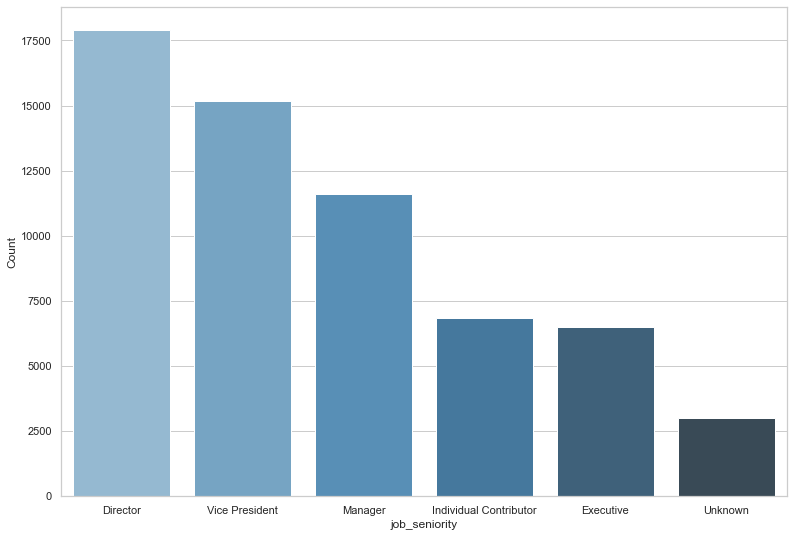

In [15]:
sns.set_theme(style="whitegrid")
plt.subplots(figsize = (13,9))
sns.barplot(x="job_seniority", y="Count", data=df3, palette="Blues_d");

> Based on the distribution of the job seniorities of people that a seller will first try to contact within a company, a seller would start with Directors or upper level management. 
> > Note: Executives are 2nd to last, but there could be potential reasons to address this.

### Question 4. Describe the distribution of the mixture of job seniorities of people that a seller will touch during the entire engagement with a company.
Keep in mind that you get to decide what “mixture” means, so do begin your answer by defining it - and explaining why you think this definition makes sense. Again, feel free to use whatever visuals, graphs, bunch of scores, tables, writeups etc. that you think is appropriate for this question.

(Note: this question doesn't really have one right answer. It's more about your style of communicating the results.)

In [16]:
qry4 = """

SELECT industry, job_seniority, COUNT(job_seniority) AS Mix_Count FROM (
    SELECT ROW_NUMBER() OVER(PARTITION BY co.id ORDER BY co.id , t.touch_scheduled_on) AS RowNum,
    t.id,
    t.person_id,
    t.touch_scheduled_on,
    t.status, 
    t.touch_type,
    p.job_seniority, 
    co.id AS company_id,
    co.industry       
    FROM touches t 
        Inner Join persons p ON p.id = (SELECT p.Id FROM persons p WHERE p.id = t.person_id ORDER BY p.id LIMIT 1)
        Inner Join companies co ON co.id = (SELECT co.id FROM companies co WHERE co.id = p.company_id AND co.industry != '' ORDER BY co.id LIMIT 1)
    ORDER BY co.id, t.id
) t
GROUP BY industry, job_seniority
ORDER BY COUNT(job_seniority) DESC, industry

"""

df4 = pd.read_sql_query(qry4, conn)

<AxesSubplot:xlabel='job_seniority', ylabel='Mix_Count'>

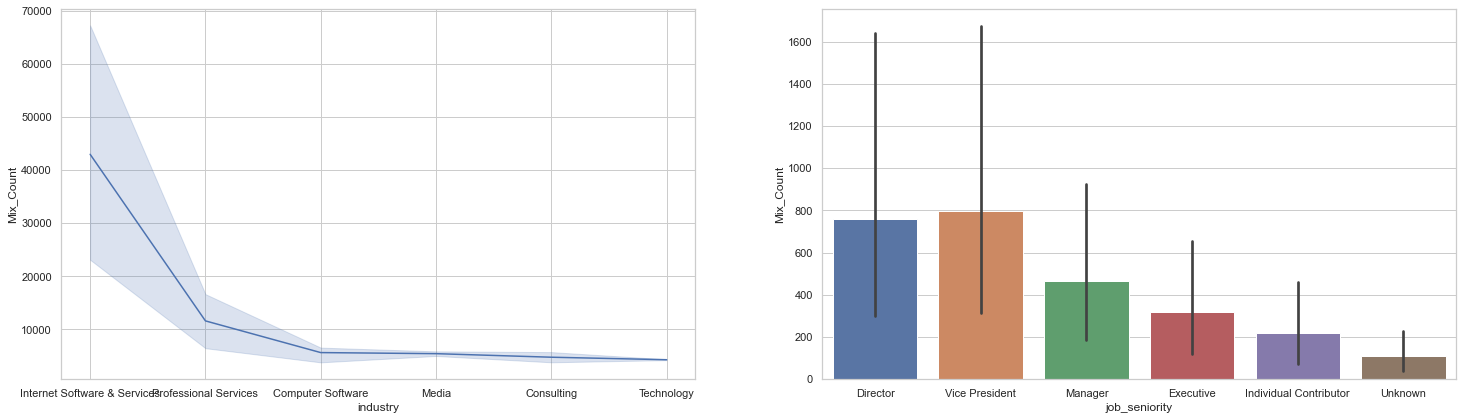

In [17]:
fig = plt.figure(figsize=(25, 15))

ax1 = fig.add_subplot(221)
sns.lineplot(x="industry", y="Mix_Count", data=df4[:20])

ax2 = fig.add_subplot(222)
sns.barplot(x="job_seniority", y="Mix_Count", data=df4)


> Quick visuals examining top 20 `industry` by `Mix_Count` and `job_seniority` by `Mix_Count`

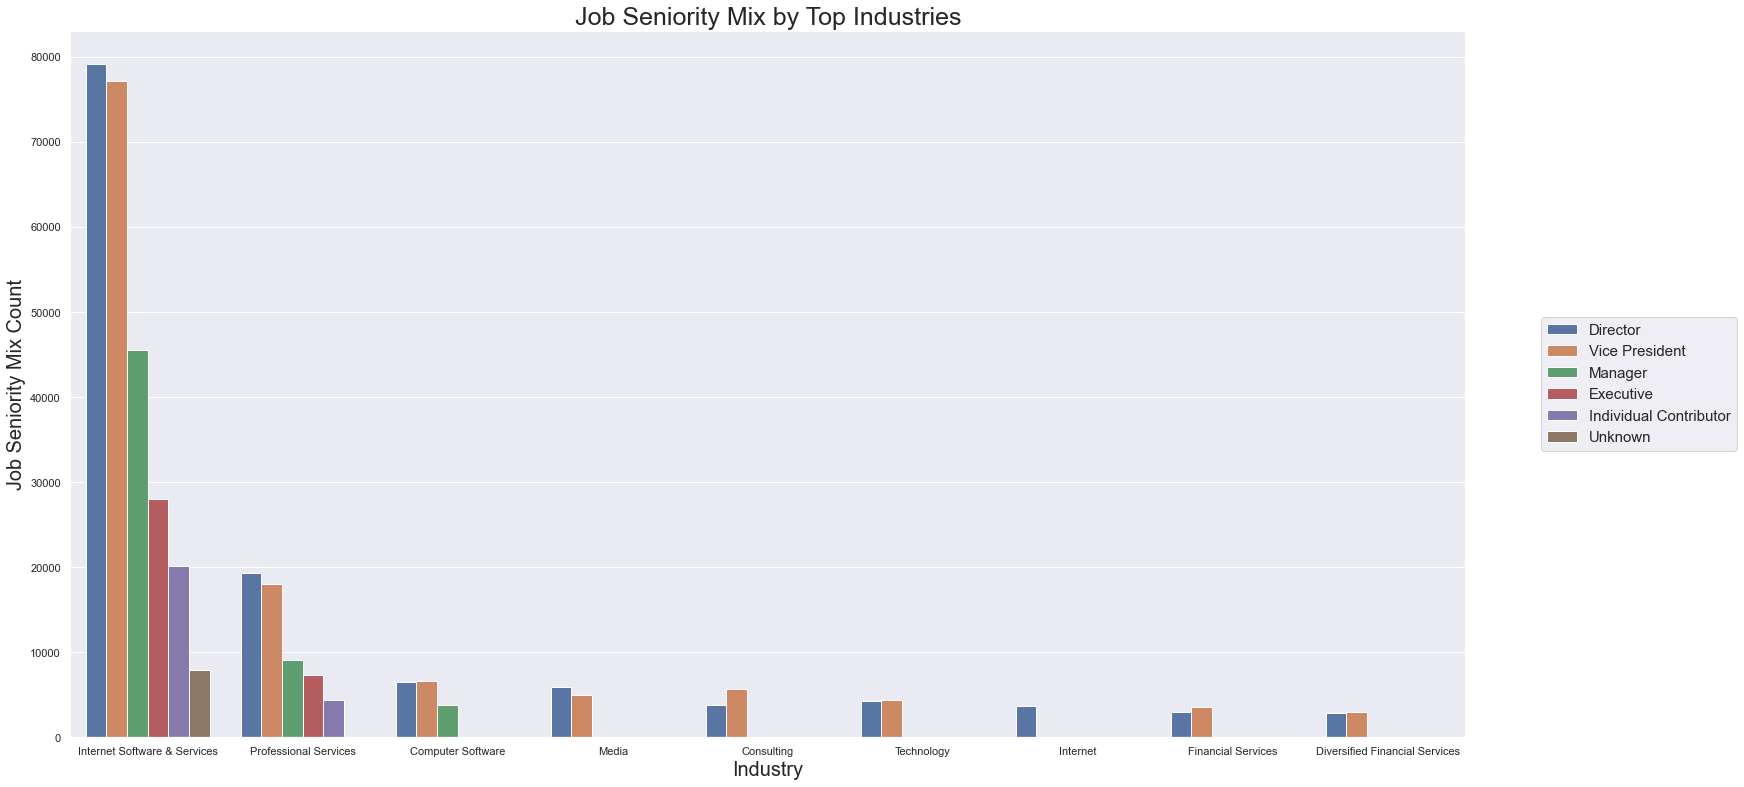

In [18]:
plt.figure(figsize=(25, 13))
sns.set_style("darkgrid")
p = sns.barplot(x="industry", y="Mix_Count", hue="job_seniority", data=df4[:25])
p.set_xlabel("Industry", fontsize = 20)
p.set_ylabel("Job Seniority Mix Count", fontsize = 20)
plt.title("Job Seniority Mix by Top Industries", fontsize = 25)
plt.legend(loc='center right', bbox_to_anchor=(1.2, 0.5), ncol=1, fontsize=15)

> Here we define "mixture" as the job seniorities or titles of people within an organization that a seller will touch during the entire engagement with a company. The above graph shows that a seller would start with Directors and Vice Presidentsof a company when observing the top industries that are being touched on.

### Question 5. Build an algorithm that, when a seller is about to contact a company it never reached out to before, recommends the best/optimal mixture of job seniorities (with “mixture” as defined by you in Question 4.) they should be targeting within that company during the entire engagement.

This is the hardest question in this exercise. If you feel you have a good idea what the algorithm should look like but either feel uncomfortable coding-wise or feel pressed for time, it is perfectly OK to describe your idea in words. Be clear, explain both what it does and why you think this is the right approach.

Whether or not you go the code-route or writeup-route, be sure to explain the assumptions and choices you made, why you made them and how you would test them.

(Note: like with the previous two questions, this question doesn't really have one right answer either!)

> To address this question, I would build an algorithm that would use a model to predict which job seniority/person to touch on based prior engagements within a company in a specific industry. I would also incorporate into the logic the touch status and opportunities to measure the success of an engagement. The algorithm would then predict and recommend the best/optimal mixture of job seniorities a seller should target during the entire engagement. 

In [19]:
conn.close()